In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_SET = os.path.join(os.getcwd(), 'data-set')

In [90]:
train = pd.read_json(os.path.join(DATA_SET, 'train.json'))
test = pd.read_json(os.path.join(DATA_SET, 'test.json'))

## Data Exploration

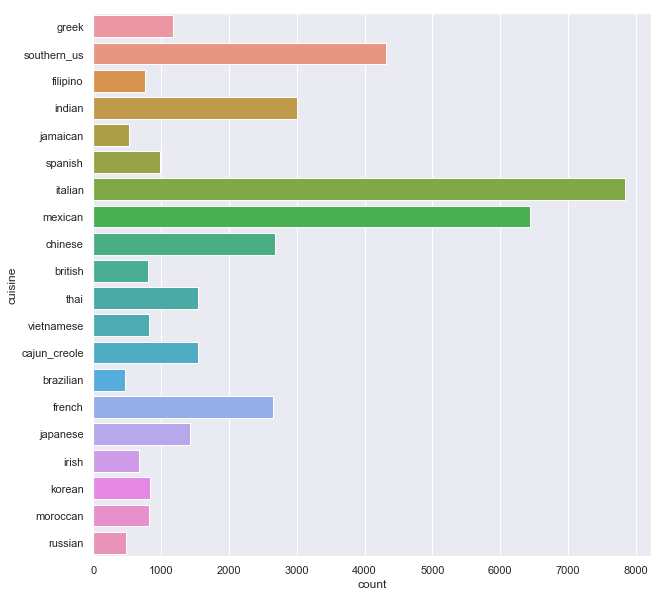

In [4]:
sns.set(rc={'figure.figsize':(10, 10)})
ax = sns.countplot(y='cuisine', data=train)
fig = ax.get_figure()
fig.savefig('figures/cuisine-distribution.png')

In [5]:
train['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [6]:
len(train['cuisine'].unique())

20

## Data Preprocessing

#### 1a. Count up the frequency of ingredients

In [7]:
from collections import defaultdict

In [8]:
def get_ingredient_freq(df, col='ingredients'):
    ingredients = defaultdict(int)
    for row in df.itertuples():
        for ingredient in getattr(row, col):
            ingredients[ingredient] += 1
    
    most_common_ingredients = sorted(ingredients, key=ingredients.get, reverse=True)
    ingredient_count = pd.concat([pd.DataFrame(list(ingredients.keys()), columns=[col]), 
                                  pd.DataFrame(list(ingredients.values()), columns=['count'])], 
                                 axis=1)
    return ingredient_count.sort_values(by=['count'], ascending=False)

In [9]:
df = get_ingredient_freq(train)

In [10]:
df.iloc[:10]

,ingredients,count
11,salt,18049
54,olive oil,7972
35,onions,7972
29,water,7457
3,garlic,7380
47,sugar,6434
105,garlic cloves,6237
27,butter,4848
13,ground black pepper,4785
115,all-purpose flour,4632


In [11]:
print('There are {} different kinds of ingredients!'.format(df.shape[0]))

There are 6714 different kinds of ingredients!


#### 1b. Visualize common ingredients

Top 10 most common ingredients

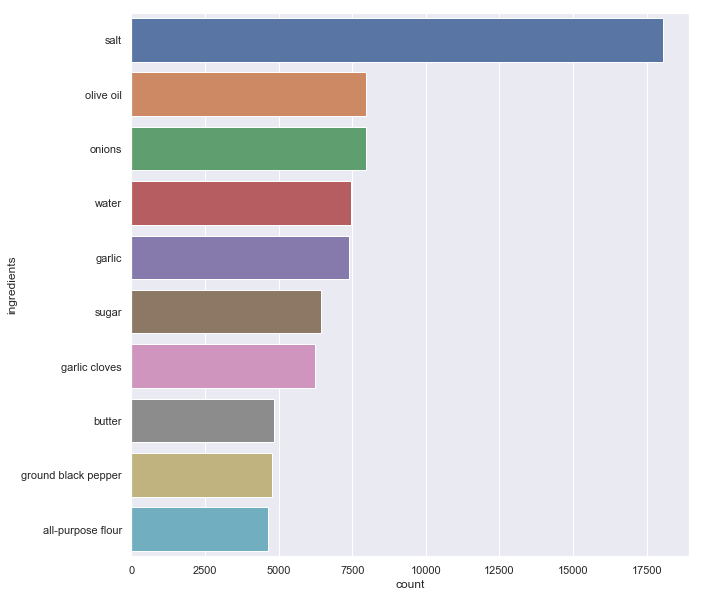

In [12]:
sns.set(rc={'figure.figsize':(10, 10)})
common_ax = sns.barplot(y='ingredients', x='count', data=df.head(10))
common_fig = common_ax.get_figure()
common_fig.savefig('figures/10-most-common-ingredients.png', bbox_inches='tight')

Filter out most common ingredients

In [13]:
ten_most_common_ing = df.head(10)['ingredients'].values

def filter_common_ingredients(df):
    return df[~df['ingredients'].isin(ten_most_common_ing)]

Top 10 most common ingredients for `Italian`

In [14]:
italian = train[train['cuisine'] == 'italian']
italian_ing = get_ingredient_freq(italian)
italian_ing = filter_common_ingredients(italian_ing)

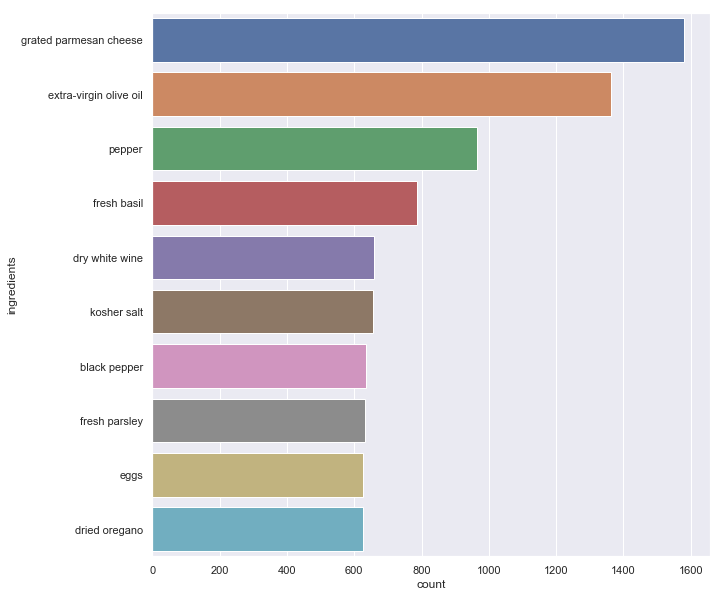

In [15]:
sns.set(rc={'figure.figsize':(10, 10)})
italian_ax = sns.barplot(y='ingredients', x='count', data=italian_ing.head(10))
italian_fig = italian_ax.get_figure()
italian_fig.savefig('figures/italian-most-common-ingredients.png', bbox_inches='tight')

Top 10 most common ingredients for `Mexican`

In [16]:
mexican = train[train['cuisine'] == 'mexican']
mexican_ing = get_ingredient_freq(mexican)
mexican_ing = filter_common_ingredients(mexican_ing)

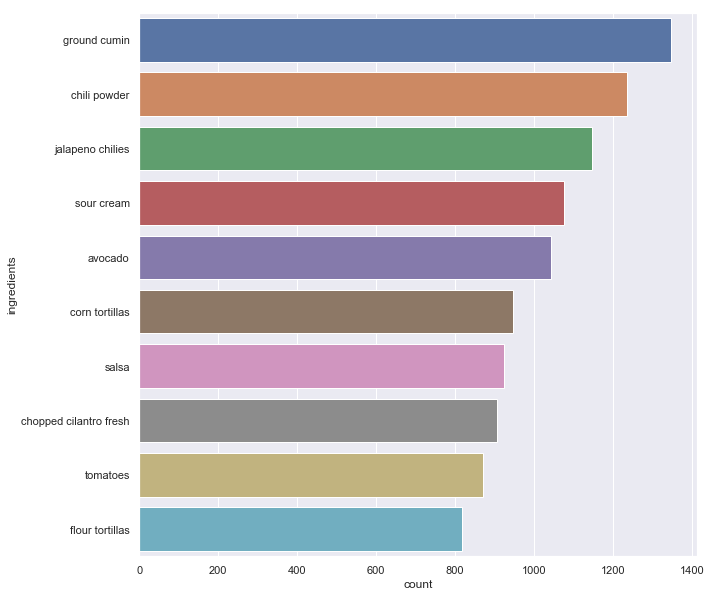

In [17]:
sns.set(rc={'figure.figsize':(10, 10)})
mexican_ax = sns.barplot(y='ingredients', x='count', data=mexican_ing.head(10))
mexican_fig = mexican_ax.get_figure()
mexican_fig.savefig('figures/mexican-most-common-ingredients.png', bbox_inches='tight')

#### Helpfer function: show ingredients that contain a specific word

In [18]:
def find_ingredients(df, word):
    if 'ingredient' not in df.columns:
        print('Error: Need to have an ingredients column!')
        return
    
    if len(word.split()) == 1:
        word = ' {0}|{0} '.format(word) 
    
    return df[df['ingredient'].str.contains(word, na=False)]

#### 2. Replacing similar ingredients

In [19]:
import re

In [20]:
descriptors = dict.fromkeys(['chopped ', ' chopped', 'minced ', ' minced', 'diced ', ' diced', 'fresh ', ' fresh', 
                             'toasted ', ' toasted', 'large ', ' large', 'small ', ' small', 'medium ', ' medium', 
                             'crushed ', ' crushed', 'canned ', ' canned', 'low sodium ', ' low sodium', 
                             'roasted ', ' roasted', 'salted ', ' salted', 'unsalted ', ' unsalted', 
                             'granulated ', ' granulated', 'dried ', ' dried', 'unsweetened ', ' unsweetened', 
                             'sweetened ', ' sweetened', 'lean ', ' lean', 'ground ', ' ground'], 
                            '')

descriptors_pattern = re.compile('|'.join(descriptors.keys()))

In [21]:
olive_oil = dict.fromkeys(['extra-virgin olive oil', 'olive oil flavored cooking spray', 'olive oil cooking spray',
                           'mild olive oil', 'olive oil spray', 'pure olive oil', 'extra light olive oil', 
                           'virgin olive oil', 'garlic olive oil', 'lemon olive oil', 'basil olive oil'], 
                          'olive oil')

olive_oil['vegetable oil'] = 'oil'
olive_oil_pattern = re.compile('|'.join(olive_oil.keys()))

In [22]:
def replace_similar_ingredients(ingredient):
    """This function will replace, remove, or modify the ingredients so we have a better representation of the ingredients."""

    # Removes descriptive words such as 'chopped', 'minced', 'large', 'fresh', etc.
    ingredient = descriptors_pattern.sub(lambda m: descriptors[m.group(0)], ingredient)
    
    # Aggregates all olive oil variants into olive oil
    ingredient = olive_oil_pattern.sub(lambda m: olive_oil[m.group(0)], ingredient)
    
    # Specific ingredient replacements
    ingredient = ingredient.replace('hardboiled egg', 'egg') # Use hardboiled because we only retain letters
    ingredient = ingredient.replace('garlic cloves', 'garlic')
    
    return ingredient

In [23]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bluebehree/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [25]:
def clean_ingredient_list(ingredients):
    # Removes all non-punctuation
    letters_pattern = re.compile('[^a-zA-Z ]')
    ingredients = [letters_pattern.sub('', ingredient) for ingredient in ingredients]
    
    ingredients = [ingredient.lower() for ingredient in ingredients]
    ingredients = [replace_similar_ingredients(ingredient) for ingredient in ingredients]
    ingredients = [wordnet_lemmatizer.lemmatize(ingredient) for ingredient in ingredients]
    
    return ingredients

In [91]:
def clean_data(train, test):
    train['set'] = 'train'
    test['set'] = 'test'
    
    data = pd.concat([train, test], sort=True, ignore_index=True)
    
    train.drop(columns='set', inplace=True)
    test.drop(columns='set', inplace=True)
    
    data['ingredients_clean'] = data['ingredients'].apply(clean_ingredient_list)
    data['ingredients_string'] = data['ingredients_clean'].apply(lambda ingredients: ' '.join(ingredients))
    
#     data.drop(columns=['ingredients', 'ingredients_clean'], inplace=True)
    data.drop(columns=['ingredients'], inplace=True)
    
    train = data.loc[data['set']=='train'].drop(columns='set')
    test = data.loc[data['set']=='test'].drop(columns=['set', 'cuisine'])

    train.drop(columns=['ingredients_clean']).to_csv(os.path.join(DATA_SET, 'train_processed.csv'), index=False)
    test.drop(columns=['ingredients_clean']).to_csv(os.path.join(DATA_SET, 'test_processed.csv'), index=False)
    
    return train, test

In [92]:
train_processed, test_processed = clean_data(train, test)

#### 3. Convert cuisine classes using LabelEncoder

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
data = pd.read_csv('data-set/train_processed.csv')

In [30]:
number_of_cuisines = len(data['cuisine'].unique())
print('There are {} unique cuisines.'.format(number_of_cuisines))

There are 20 unique cuisines.


In [31]:
lb = LabelEncoder()

In [32]:
target = lb.fit_transform(data['cuisine'])

In [33]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [34]:
cuisine_list = [lb.inverse_transform([i])[0] for i in range(20)]

#### 4. Convert words to a vector using tf-idf vectorizer

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
corpus = data['ingredients_string']

In [37]:
tfidf = TfidfVectorizer(stop_words='english', binary=False, max_df=.6, analyzer='word', 
                        ngram_range=(1,1), sublinear_tf=False, token_pattern=r'\w+', norm='l2')

In [38]:
matrix = tfidf.fit_transform(data['ingredients_string'])

#### 5. Split train and test set

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(matrix, target, test_size=0.3, random_state=101)

## Train and test model

In [41]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [42]:
clf_svc = LinearSVC(random_state=101)
clf_nb = MultinomialNB()
clf_dt = DecisionTreeClassifier(random_state=101)
clf_rfc = RandomForestClassifier()
clf_xgb = xgb.XGBClassifier()

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [44]:
from timeit import default_timer as timer

In [46]:
def train_and_test(clf, X_train, X_test, y_train, y_test):
    start = timer()
    clf.fit(X_train, y_train)
    end = timer()
    total_time = end - start
    print('Training time: {0:.2f}s\n'.format(total_time))
    
    train_pred = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    train_score = f1_score(y_train, train_pred, average='weighted')
    test_score = f1_score(y_test, y_pred, average='weighted')
    
    print('Training score: {}'.format(train_score))
    print('Testing score: {}\n'.format(test_score))
    
    print(classification_report(y_test, y_pred, target_names=cuisine_list))
    
    return clf, train_score, test_score, total_time

In [47]:
print('Training and testing a Linear SVM Classifier...')
clf_svc, svc_train_score, svc_test_score, svc_time = train_and_test(clf_svc, X_train, X_test, y_train, y_test)

Training and testing a Linear SVM Classifier...
Training time: 1.96s

Training score: 0.8616584527860537
Testing score: 0.7863891870650522

              precision    recall  f1-score   support

   brazilian       0.84      0.59      0.70       135
     british       0.65      0.44      0.53       246
cajun_creole       0.73      0.70      0.71       474
     chinese       0.79      0.86      0.83       792
    filipino       0.75      0.60      0.67       230
      french       0.62      0.62      0.62       784
       greek       0.79      0.74      0.76       329
      indian       0.87      0.90      0.89       910
       irish       0.70      0.59      0.64       198
     italian       0.81      0.89      0.85      2316
    jamaican       0.83      0.76      0.79       143
    japanese       0.84      0.69      0.76       431
      korean       0.84      0.77      0.80       258
     mexican       0.89      0.92      0.91      1911
    moroccan       0.80      0.79      0.79      

In [48]:
print('Training and testing a Naive Bayes Classifier...')
clf_nb, nb_train_score, nb_test_score, nb_time = train_and_test(clf_nb, X_train, X_test, y_train, y_test)

Training and testing a Naive Bayes Classifier...
Training time: 0.04s

Training score: 0.6433276740777103
Testing score: 0.6190226840746009

              precision    recall  f1-score   support

   brazilian       1.00      0.16      0.27       135
     british       1.00      0.05      0.10       246
cajun_creole       0.78      0.49      0.60       474
     chinese       0.58      0.91      0.71       792
    filipino       0.96      0.10      0.17       230
      french       0.53      0.39      0.45       784
       greek       0.90      0.29      0.44       329
      indian       0.76      0.90      0.83       910
       irish       1.00      0.05      0.10       198
     italian       0.64      0.90      0.75      2316
    jamaican       1.00      0.13      0.22       143
    japanese       0.92      0.53      0.67       431
      korean       0.99      0.33      0.49       258
     mexican       0.80      0.91      0.85      1911
    moroccan       0.96      0.28      0.43     

In [49]:
print('Training and testing a Decision Tree Classifier...')
clf_dt, dt_train_score, dt_test_score, dt_time = train_and_test(clf_dt, X_train, X_test, y_train, y_test)

Training and testing a Decision Tree Classifier...
Training time: 8.25s

Training score: 0.9994971374262186
Testing score: 0.6146958917665544

              precision    recall  f1-score   support

   brazilian       0.48      0.40      0.44       135
     british       0.28      0.26      0.27       246
cajun_creole       0.51      0.51      0.51       474
     chinese       0.69      0.66      0.67       792
    filipino       0.40      0.40      0.40       230
      french       0.39      0.40      0.39       784
       greek       0.53      0.57      0.55       329
      indian       0.75      0.74      0.75       910
       irish       0.38      0.33      0.35       198
     italian       0.70      0.76      0.73      2316
    jamaican       0.55      0.51      0.53       143
    japanese       0.56      0.56      0.56       431
      korean       0.54      0.52      0.53       258
     mexican       0.81      0.81      0.81      1911
    moroccan       0.55      0.44      0.49   

In [50]:
print('Training and testing a Random Forest Classifier')
clf_rfc, rfc_train_score, rfc_test_score, rfc_time = train_and_test(clf_rfc, X_train, X_test, y_train, y_test)

Training and testing a Random Forest Classifier


/Users/bluebehree/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training time: 4.76s

Training score: 0.9942837394786534
Testing score: 0.6779537805776711

              precision    recall  f1-score   support

   brazilian       0.70      0.50      0.58       135
     british       0.44      0.27      0.33       246
cajun_creole       0.60      0.59      0.60       474
     chinese       0.67      0.84      0.74       792
    filipino       0.62      0.38      0.47       230
      french       0.46      0.47      0.47       784
       greek       0.70      0.52      0.60       329
      indian       0.76      0.88      0.82       910
       irish       0.63      0.31      0.42       198
     italian       0.68      0.88      0.77      2316
    jamaican       0.80      0.45      0.58       143
    japanese       0.74      0.58      0.65       431
      korean       0.81      0.52      0.63       258
     mexican       0.83      0.89      0.86      1911
    moroccan       0.81      0.53      0.64       247
     russian       0.56      0.16      0.25

In [51]:
print('Training and testing a XGBoost Classifier...')
clf_xgb, xgb_train_score, xgb_test_score, xgb_time = train_and_test(clf_xgb, X_train, X_test, y_train, y_test)

Training and testing a XGBoost Classifier...
Training time: 131.77s

Training score: 0.7691493049677516
Testing score: 0.7190395842149496

              precision    recall  f1-score   support

   brazilian       0.86      0.47      0.61       135
     british       0.78      0.25      0.38       246
cajun_creole       0.76      0.66      0.71       474
     chinese       0.74      0.83      0.78       792
    filipino       0.74      0.43      0.54       230
      french       0.55      0.48      0.51       784
       greek       0.81      0.67      0.73       329
      indian       0.86      0.85      0.86       910
       irish       0.75      0.42      0.54       198
     italian       0.66      0.89      0.76      2316
    jamaican       0.87      0.64      0.73       143
    japanese       0.87      0.59      0.70       431
      korean       0.85      0.64      0.73       258
     mexican       0.86      0.89      0.88      1911
    moroccan       0.89      0.68      0.77       

## Visualizing results

In [52]:
def get_model_names(models):
    model_names = []
    
    for model in models:
        model_names += [model] * 2
    
    return model_names

In [ ]:
clf_svc = LinearSVC(random_state=101)
clf_nb = MultinomialNB()
clf_dt = DecisionTreeClassifier(random_state=101)
clf_rfc = RandomForestClassifier()
clf_xgb = xgb.XGBClassifier()

In [54]:
model_names = get_model_names(['LinearSVC', 'MultinomialNB', 'DecisionTreeClassifier', 
                               'RandomForestClassifier', 'XGBClassifier'])
scores = [svc_train_score, svc_test_score, nb_train_score, nb_test_score, 
          dt_train_score, dt_test_score, rfc_train_score, rfc_test_score, 
          xgb_train_score, xgb_test_score]

types = ['train score', 'test score'] * 5

In [58]:
d = {'model': model_names, 'score': scores, 'types': types}

In [60]:
results = pd.DataFrame(data=d)

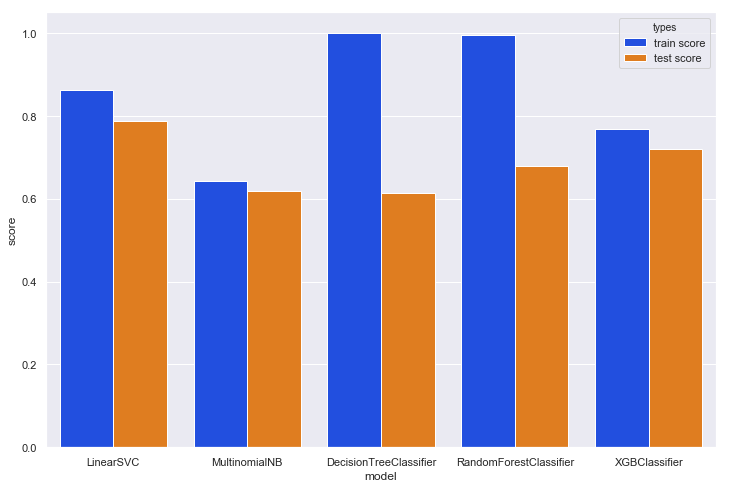

In [81]:
sns.set(rc={'figure.figsize':(12, 8)})
results_ax = sns.barplot(x='model', y='score', hue='types', data=results, palette='bright')
results_fig = results_ax.get_figure()
results_fig.savefig('figures/results.png', bbox_inches='tight')

In [68]:
models = ['LinearSVC', 'MultinomialNB', 'DecisionTreeClassifier', 
          'RandomForestClassifier', 'XGBClassifier']

training_time = [svc_time, nb_time, dt_time, rfc_time, xgb_time]

In [70]:
times = pd.DataFrame({'model': models, 'training time': training_time})

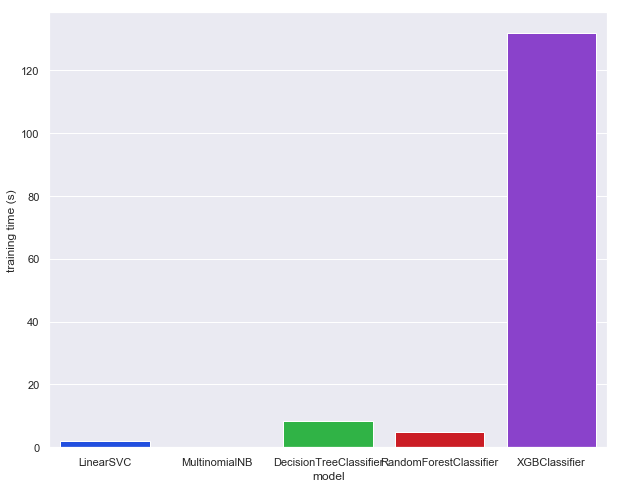

In [78]:
sns.set(rc={'figure.figsize':(10, 8)})
times_ax = sns.barplot(x='model', y='training time', data=times, palette='bright')
plt.ylabel('training time (s)')
times_fig = times_ax.get_figure()
times_fig.savefig('figures/training_times.png', bbox_inches='tight')

## Optimizing Linear SVC

In [56]:
def optimize_model(clf, X_train, y_train):
    parameters = {'C':(1, 0.1, 0.01, 0.05, 0.5, 0.001), 'max_iter':(500, 1000, 2000, 5000, 10000)}

    gs = GridSearchCV(estimator=clf, param_grid=parameters, cv=5)
    gs.fit(X_train, y_train)
    
    return gs.best_estimator_

In [57]:
clf = LinearSVC(random_state=101)
clf = optimize_model(clf, X_train, y_train)

In [58]:
print('Training and testing on best Linear SVM classifier...')
clf = train_and_test(clf, X_train, X_test, y_train, y_test)

Training and testing on best Linear SVM classifier...
Training time: 1.58s

Training score: 0.8475415836091549
Testing score: 0.7865935975062768

              precision    recall  f1-score   support

   brazilian       0.86      0.58      0.69       135
     british       0.71      0.44      0.54       246
cajun_creole       0.74      0.69      0.71       474
     chinese       0.78      0.87      0.82       792
    filipino       0.77      0.59      0.67       230
      french       0.62      0.62      0.62       784
       greek       0.82      0.73      0.77       329
      indian       0.87      0.91      0.89       910
       irish       0.69      0.55      0.61       198
     italian       0.81      0.90      0.85      2316
    jamaican       0.83      0.73      0.78       143
    japanese       0.85      0.69      0.76       431
      korean       0.86      0.76      0.80       258
     mexican       0.89      0.93      0.91      1911
    moroccan       0.81      0.79      0.80

In [79]:
clf.get_params

<bound method BaseEstimator.get_params of LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=500,
     multi_class='ovr', penalty='l2', random_state=101, tol=0.0001,
     verbose=0)>

## Get Test Predictions

In [60]:
test_data = pd.read_csv('data-set/test_processed.csv')

In [71]:
corpus = pd.concat([data['ingredients_string'], test_data['ingredients_string']], ignore_index=True)

In [73]:
matrix = tfidf.fit_transform(corpus)

In [76]:
train_matrix = matrix[:data.shape[0]]

In [78]:
test_matrix = matrix[data.shape[0]:]

In [80]:
clf_final = LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, 
                      loss='squared_hinge', max_iter=500, multi_class='ovr', penalty='l2', 
                      random_state=101, tol=0.0001, verbose=0)

In [83]:
start = timer()
clf_final.fit(train_matrix, target)
end = timer()
print('Training time: {0:.2f}s\n'.format(end-start))

train_pred = clf_final.predict(train_matrix)
print('Training score: {}'.format(f1_score(target, train_pred, average='weighted')))
print(classification_report(target, train_pred, target_names=cuisine_list))

Training time: 2.03s

Training score: 0.8426595474942989
              precision    recall  f1-score   support

   brazilian       0.88      0.65      0.75       467
     british       0.77      0.58      0.66       804
cajun_creole       0.84      0.78      0.81      1546
     chinese       0.84      0.91      0.87      2673
    filipino       0.85      0.71      0.77       755
      french       0.70      0.72      0.71      2646
       greek       0.86      0.79      0.83      1175
      indian       0.89      0.94      0.91      3003
       irish       0.81      0.60      0.69       667
     italian       0.85      0.92      0.89      7838
    jamaican       0.90      0.79      0.85       526
    japanese       0.90      0.76      0.82      1423
      korean       0.89      0.86      0.87       830
     mexican       0.93      0.95      0.94      6438
    moroccan       0.89      0.85      0.87       821
     russian       0.80      0.62      0.70       489
 southern_us       0.78 

In [85]:
test_pred = clf_final.predict(test_matrix)

In [88]:
test_pred = lb.inverse_transform(test_pred)

In [95]:
output = test_data.copy()
output['cuisine'] = test_pred

In [96]:
output.drop(columns=['ingredients_string'], inplace=True)

In [98]:
output.to_csv('data-set/submission.csv', index=False)

## Free-form Visualizations

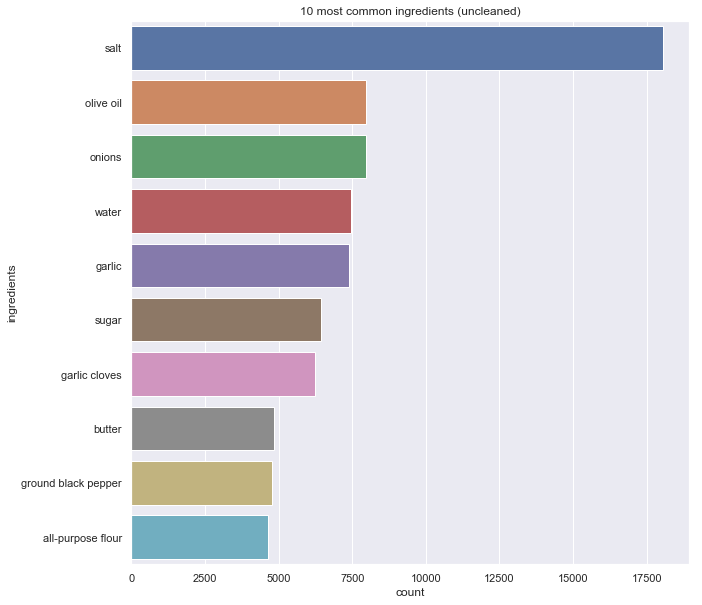

In [112]:
sns.set(rc={'figure.figsize':(10, 10)})
common_ax = sns.barplot(y='ingredients', x='count', data=df.head(10))
plt.title('10 most common ingredients (uncleaned)')
common_fig = common_ax.get_figure()
common_fig.savefig('figures/10-most-common-ingredients-uncleaned.png', bbox_inches='tight')

In [100]:
processed_freq = get_ingredient_freq(train_processed, col='ingredients_clean')

In [106]:
processed_freq.rename(index=str, columns={'ingredients_clean': 'ingredients'}, inplace=True)

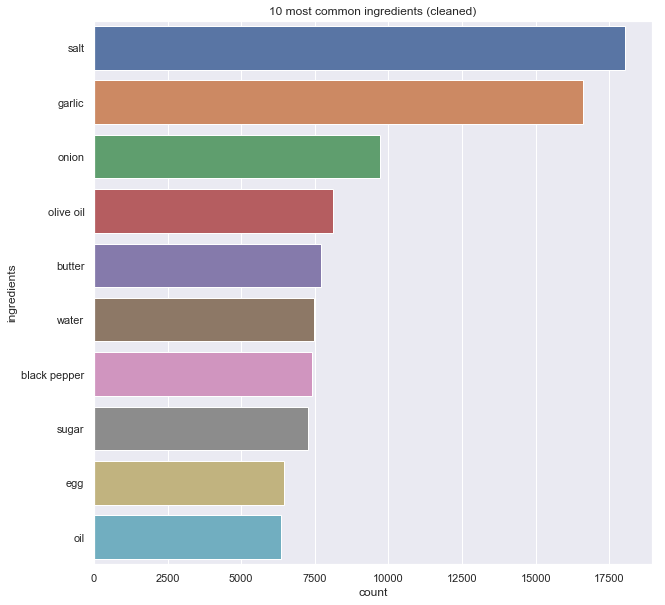

In [111]:
sns.set(rc={'figure.figsize':(10, 10)})
ax = sns.barplot(y='ingredients', x='count', data=processed_freq.head(10))
plt.title('10 most common ingredients (cleaned)')
fig = ax.get_figure()
fig.savefig('figures/10-most-common-ingredients-cleaned.png', bbox_inches='tight')